![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

<!-- ========================================================= -->
<!--        John Snow Labs - Package Installation Guide         -->
<!--        JupyterLab Single Markdown Cell (HTML Content)      -->
<!-- ========================================================= -->

<h1>Package Installation</h1>

<!-- Link to official GitHub repository -->
<p>
  Official Repository:
  <a href="https://github.com/JohnSnowLabs/johnsnowlabs" target="_blank">
    https://github.com/JohnSnowLabs/johnsnowlabs
  </a>
</p>

<!-- License setup instructions -->
<p>
  Keep your <strong>license keys</strong> in a JSON file and point to it using the
  <code>json_license_path</code> argument when starting the Spark session.
</p>

<!-- Visual NLP configuration note -->
<p>
  Set <code>visual=True</code> while starting the Spark session to install and make
  <strong>Visual NLP libraries</strong> available.
</p>

<!-- Restart note -->
<p>
  ⚠️ <strong>Important:</strong> After installing the library, make sure to
  <strong>RESTART your session</strong> before running Spark again.
</p>

<!-- End of notebook cell -->

In [ ]:
!pip install -q johnsnowlabs

In [ ]:
from johnsnowlabs import nlp, visual, medical

nlp.install(refresh_install=True, visual=True, json_license_path="./spark_nlp_for_healthcare_spark_ocr_10538.json")

In [ ]:
### RESTART SESSION !!!!

In [2]:
from johnsnowlabs import visual, nlp

spark = nlp.start(visual=True, hardware_target="gpu", json_license_path="./spark_nlp_for_healthcare_spark_ocr_10538.json")

spark

Spark Session already created, some configs may not take.
👌 License info detected in file ./spark_nlp_for_healthcare_spark_ocr_10538.json


25/10/19 17:24:08 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


<h1>Table Recognition Overview</h1>

<!-- Notebook purpose -->
<p>
  This notebook covers in-depth <strong>Table Recognition</strong> features used to extract tables
  from <strong>scanned images</strong> and <strong>PDF sources</strong>.
  It demonstrates how different <em>table detection</em>, <em>cell detection</em>,
  <em>HOCR</em>, and <em>OCR</em> components can be combined to extract structured text tables.
</p>

<!-- Stages list -->
<h2>Stages Covered in this Notebook</h2>
<ul>
  <li>BinaryToImage</li>
  <li>PdfToImage</li>
  <li>ImageTableDetector</li>
  <li>ImageSplitRegions</li>
  <li>ImageTextDetectorV2</li>
  <li>ImageDocumentRegionDetector</li>
  <li>RegionsMerger</li>
  <li>ImageToTextV3</li>
  <li>HocrToTextTable</li>
  <li>ImageToTextV2</li>
  <li>ImageDrawRegions</li>
</ul>

In [3]:
# 📦 Spark OCR Imports
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import *

# ⚡ Spark NLP Core
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline

# 🔗 Spark ML
from pyspark.ml import Pipeline, PipelineModel
import pyspark.sql.functions as F

# 🧩 Spark NLP for Healthcare (JSL)
import sparknlp_jsl
from sparknlp_jsl.annotator import *

from IPython.display import display, Markdown

import pkg_resources
import pandas as pd
from io import StringIO

<h1>Table Recognition - Case Sensitive Using ImageToTextV3</h1>


    Image #0:
    Origin: file:/workspace/data/visual/tables/PIIS0092867424005385__9.jpg
    Resolution: 150 dpi
    Width: 1257 px
    Height: 1632 px
    Mode: 5
    Number of channels: 3


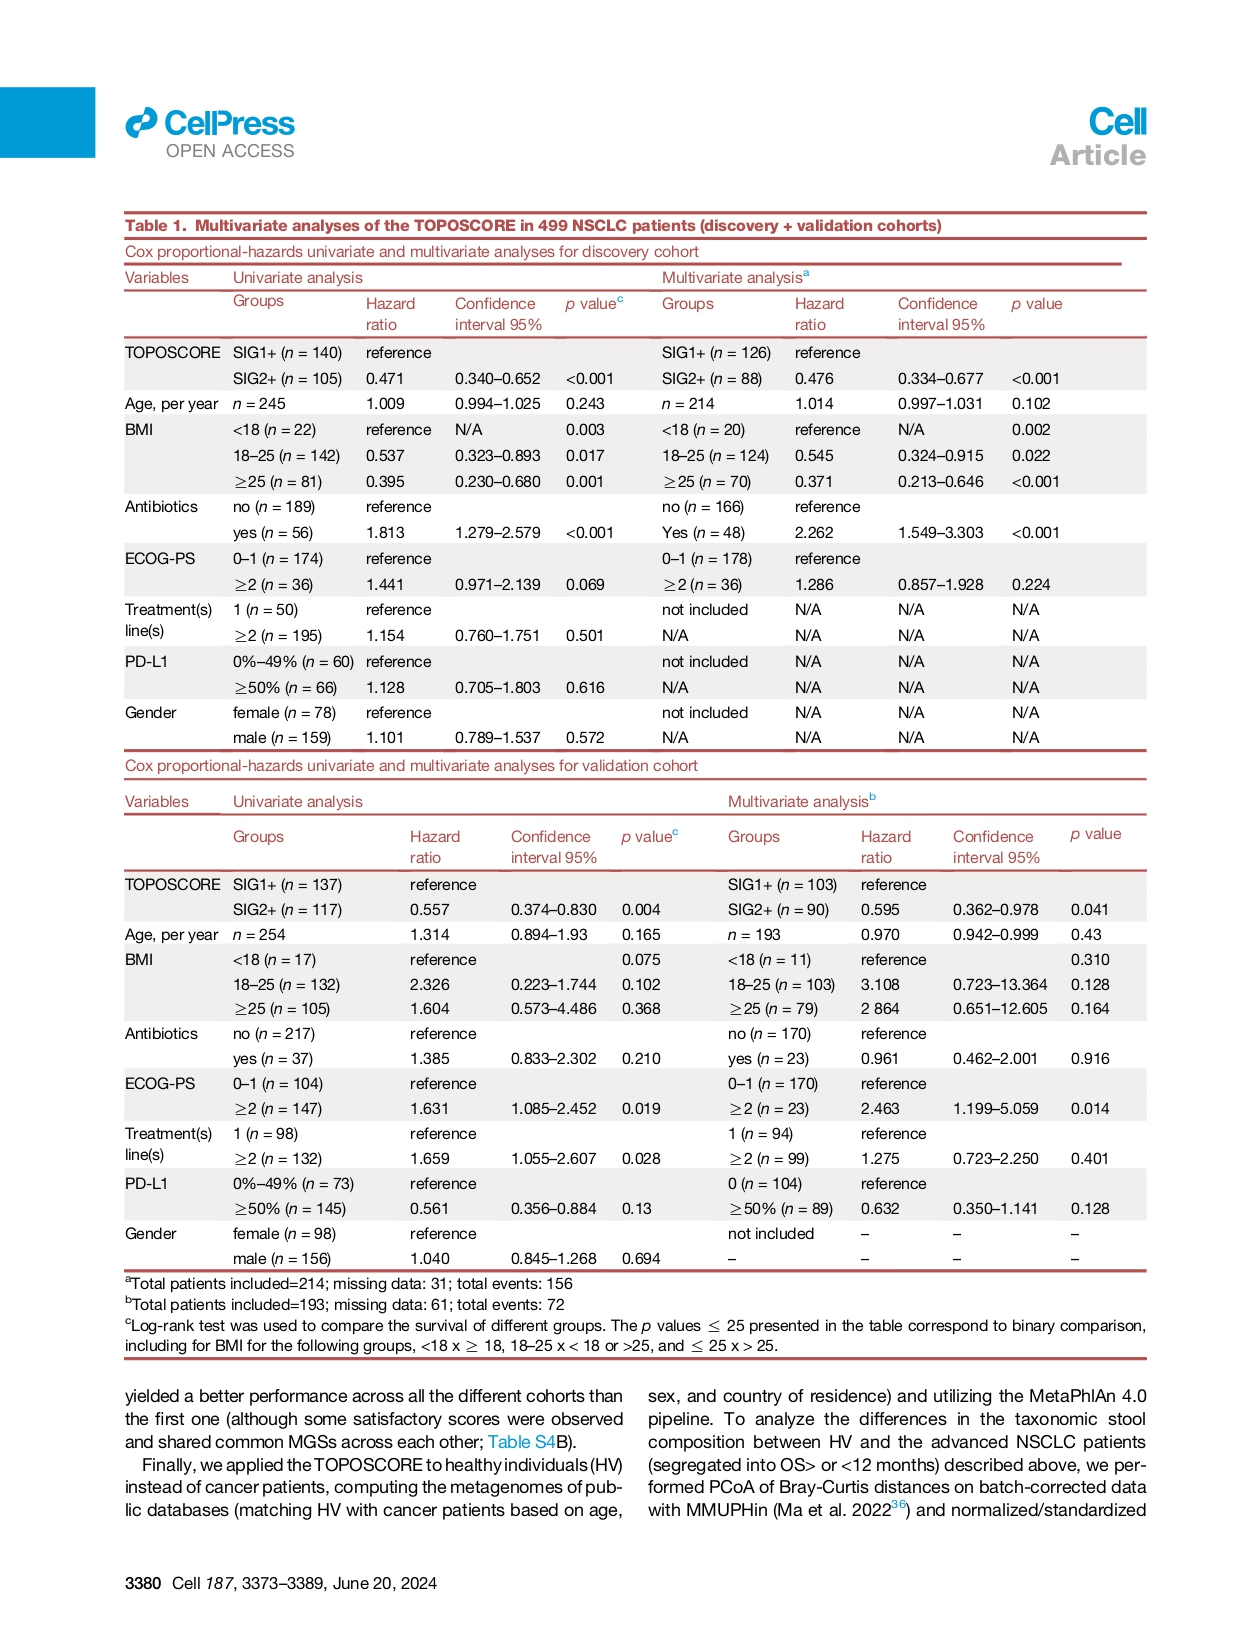

In [5]:
table_image_path = "./data/visual/tables/PIIS0092867424005385__9.jpg"

table_image_df= spark.read.format("binaryFile").load(table_image_path)

display_images(BinaryToImage().setImageType(ImageType.TYPE_3BYTE_BGR).transform(table_image_df), "image")

In [7]:
binary_to_image = BinaryToImage() \
    .setInputCol("content") \
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

table_detector = ImageTableDetector() \
    .pretrained("table_detection_v3", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("table_regions") \
    .setScoreThreshold(0.4) \
    .setApplyCorrection(True)

draw_regions_table = ImageDrawRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("table_regions") \
    .setOutputCol("image_with_table_regions") \
    .setRectColor(Color.red)

splitter = ImageSplitRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("table_regions") \
    .setOutputCol("table_image") \
    .setDropCols("image")

text_detector = ImageTextDetector() \
    .pretrained("image_text_detector_opt", "en", "clinical/ocr") \
    .setInputCol("table_image") \
    .setOutputCol("text_regions") \
    .setWithRefiner(False) \
    .setUseGPU(False) \
    .setWidth(0)

cell_detector = ImageDocumentRegionDetector() \
    .pretrained("region_cell_detection_v2", "en", "clinical/ocr") \
    .setInputCol("table_image") \
    .setOutputCol("cells") \
    .setScoreThreshold(0.8)

draw_regions_cells = ImageDrawRegions() \
    .setInputCol("table_image") \
    .setInputRegionsCol("cells") \
    .setOutputCol("image_with_cell_regions") \
    .setRectColor(Color.green)

merger = RegionsMerger() \
    .setInputCols(["text_regions"]) \
    .setCellInputCol("cells") \
    .setImageInputCol("table_image") \
    .setOutputCol("merged_regions") \
    .setKeepTextRegions(True)

img_to_hocr = ImageToTextV3() \
    .setInputCols(["table_image", "merged_regions"]) \
    .setOutputFormat(OcrOutputFormat.HOCR) \
    .setOutputCol("hocr")

hocr_to_table = HocrToTextTable() \
    .setInputCol("hocr") \
    .setOutputCol("table") \
    .setUseCellsCol("cells") \
    .setOutputFormat(TableOutputFormat.TABLE)

pipeline = PipelineModel(stages=[
    binary_to_image,
    table_detector,
    draw_regions_table,
    splitter,
    text_detector,
    cell_detector,
    draw_regions_cells,
    merger,
    img_to_hocr,
    hocr_to_table
])

table_detection_v3 download started this may take some time.
Approximate size to download 23.1 MB
image_text_detector_opt download started this may take some time.


25/10/19 17:34:14 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.
25/10/19 17:34:14 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


Approximate size to download 75.8 MB
region_cell_detection_v2 download started this may take some time.
Approximate size to download 23.1 MB


25/10/19 17:34:14 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


In [8]:
result = pipeline.transform(table_image_df).cache()

result = result.withColumn("table_id", F.monotonically_increasing_id())

result.columns

['image',
 'path',
 'modificationTime',
 'length',
 'pagenum',
 'image_with_table_regions',
 'table_image',
 'table_regions',
 'text_regions',
 'cells',
 'image_with_cell_regions',
 'merged_regions',
 'hocr',
 'positions',
 'table',
 'exception',
 'table_index',
 'table_id']

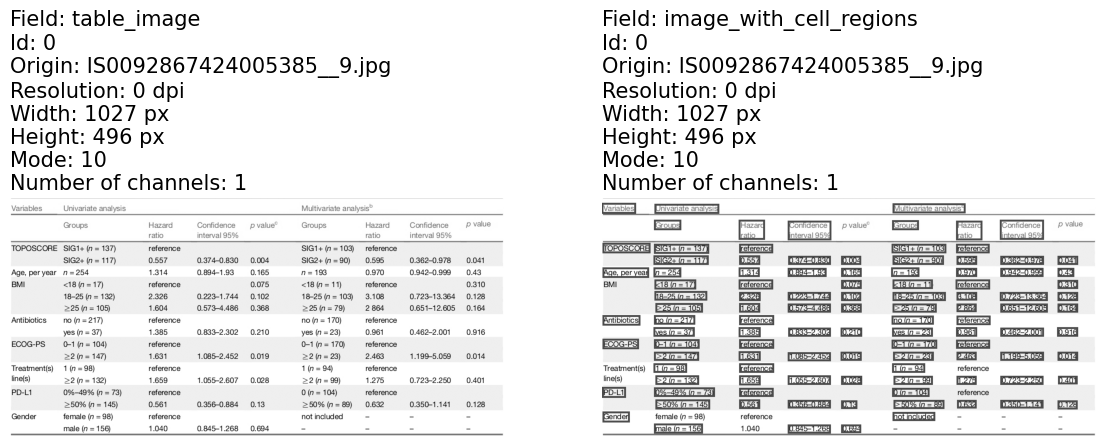

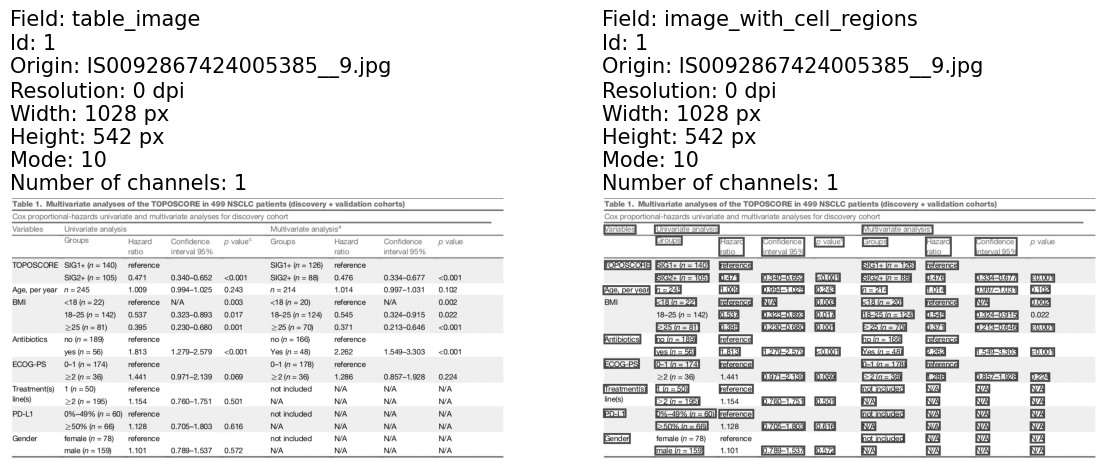

In [9]:
display_images_horizontal(result, "table_image,image_with_cell_regions")

In [10]:
display_tables(result, table_col = "table", table_index_col = "table_id", empty_val = "")

Filename: PIIS0092867424005385__9.jpg
Page: 0
Table: 0
Number of Columns: 9


col0,col1,col2,col3,col4,col5,col6,col7,col8
Treatment(s) line(s) Variables,,,,,,,,
,Univariate analysis.,,,,Multivariate analysis”,,,
,Groups,Hazard ratio,Confidence interval 95%,p value®,Groups:,Hazard ratio,Confidence interval 95%,p value
TOPOSCORE,SIGI+ (n= 137),reference,,,SIG1+ (n= 103),reference,,
,SIG2+ (n= 117),0.557,0.374-0.830,0.004,SIG2+ (n= 90),0.595,0.362-0.978,0.041
"Age, per year",n= 254,1.314,0.894-1.93,0.165,n= 193,0.970,0.942-0.999,0.43
BMI,<18 (n=17),reference,,0.075,<18 (n= 11),reference,,0.310
,18-25 (n= 132),2.326,0.223-1.744,0.102,18-25 (n= 103),3.108,0.723-13.364,0.128
,225 (n= 105),1.604,0.573-4.486,0.368,225 (n= 79),2 864,0.651-12.605,0.164
Antibiotics,no (n =217),reference,,,no! (n= 170),reference,,


Filename: PIIS0092867424005385__9.jpg
Page: 0
Table: 1
Number of Columns: 9


col0,col1,col2,col3,col4,col5,col6,col7,col8
Variables,Univariate analysis.,,,,Multivariate analysis”,,,
,Groups,Hazard ratio,Confidence interval 95%,p value®,Groups:,Hazard ratio,Confidence interval 95%,p value
TOPOSCORE,SIG1+ (n= 140),reference,,,SIG1+ (n= 126),reference,,
,SIG2+ (n= 105),0.471,0.340-0.652,<0.001,SIG2+ (n= 88),0.476,0.334-0.677,<0. .001
"Age, per year",n= 245,1.009,0.994-1.025,0.243,n= 214,1.014,0.997-1.031,0.102
BMI,<18 (n =22),reference,NA,0.003,<18 (n= 20),reference,NA,0.002
,18-25 (n= 142),0.537,0.323-0.893,0.017,18-25 (n =124),0.545,0.324-0.915,0.022
,225 (n= 81),0.395,0.230-0.680,0.001,225 (n= 70),0.371,0.213-0.646,<0.001
Antibiotics,no (n= 189),reference,,,no (n= 166),reference,,
,yes (n= 56),1.813,1.279-2.579,<0.001,Yes (n= 48),2.262,1.549-3.303,<0. 001


<h1>RegionsMerger For Improved OCR using ImageToTextV2</h1>


    Image #0:
    Origin: file:/workspace/data/visual/tables/table.png
    Resolution: 143 dpi
    Width: 2298 px
    Height: 1650 px
    Mode: 5
    Number of channels: 3


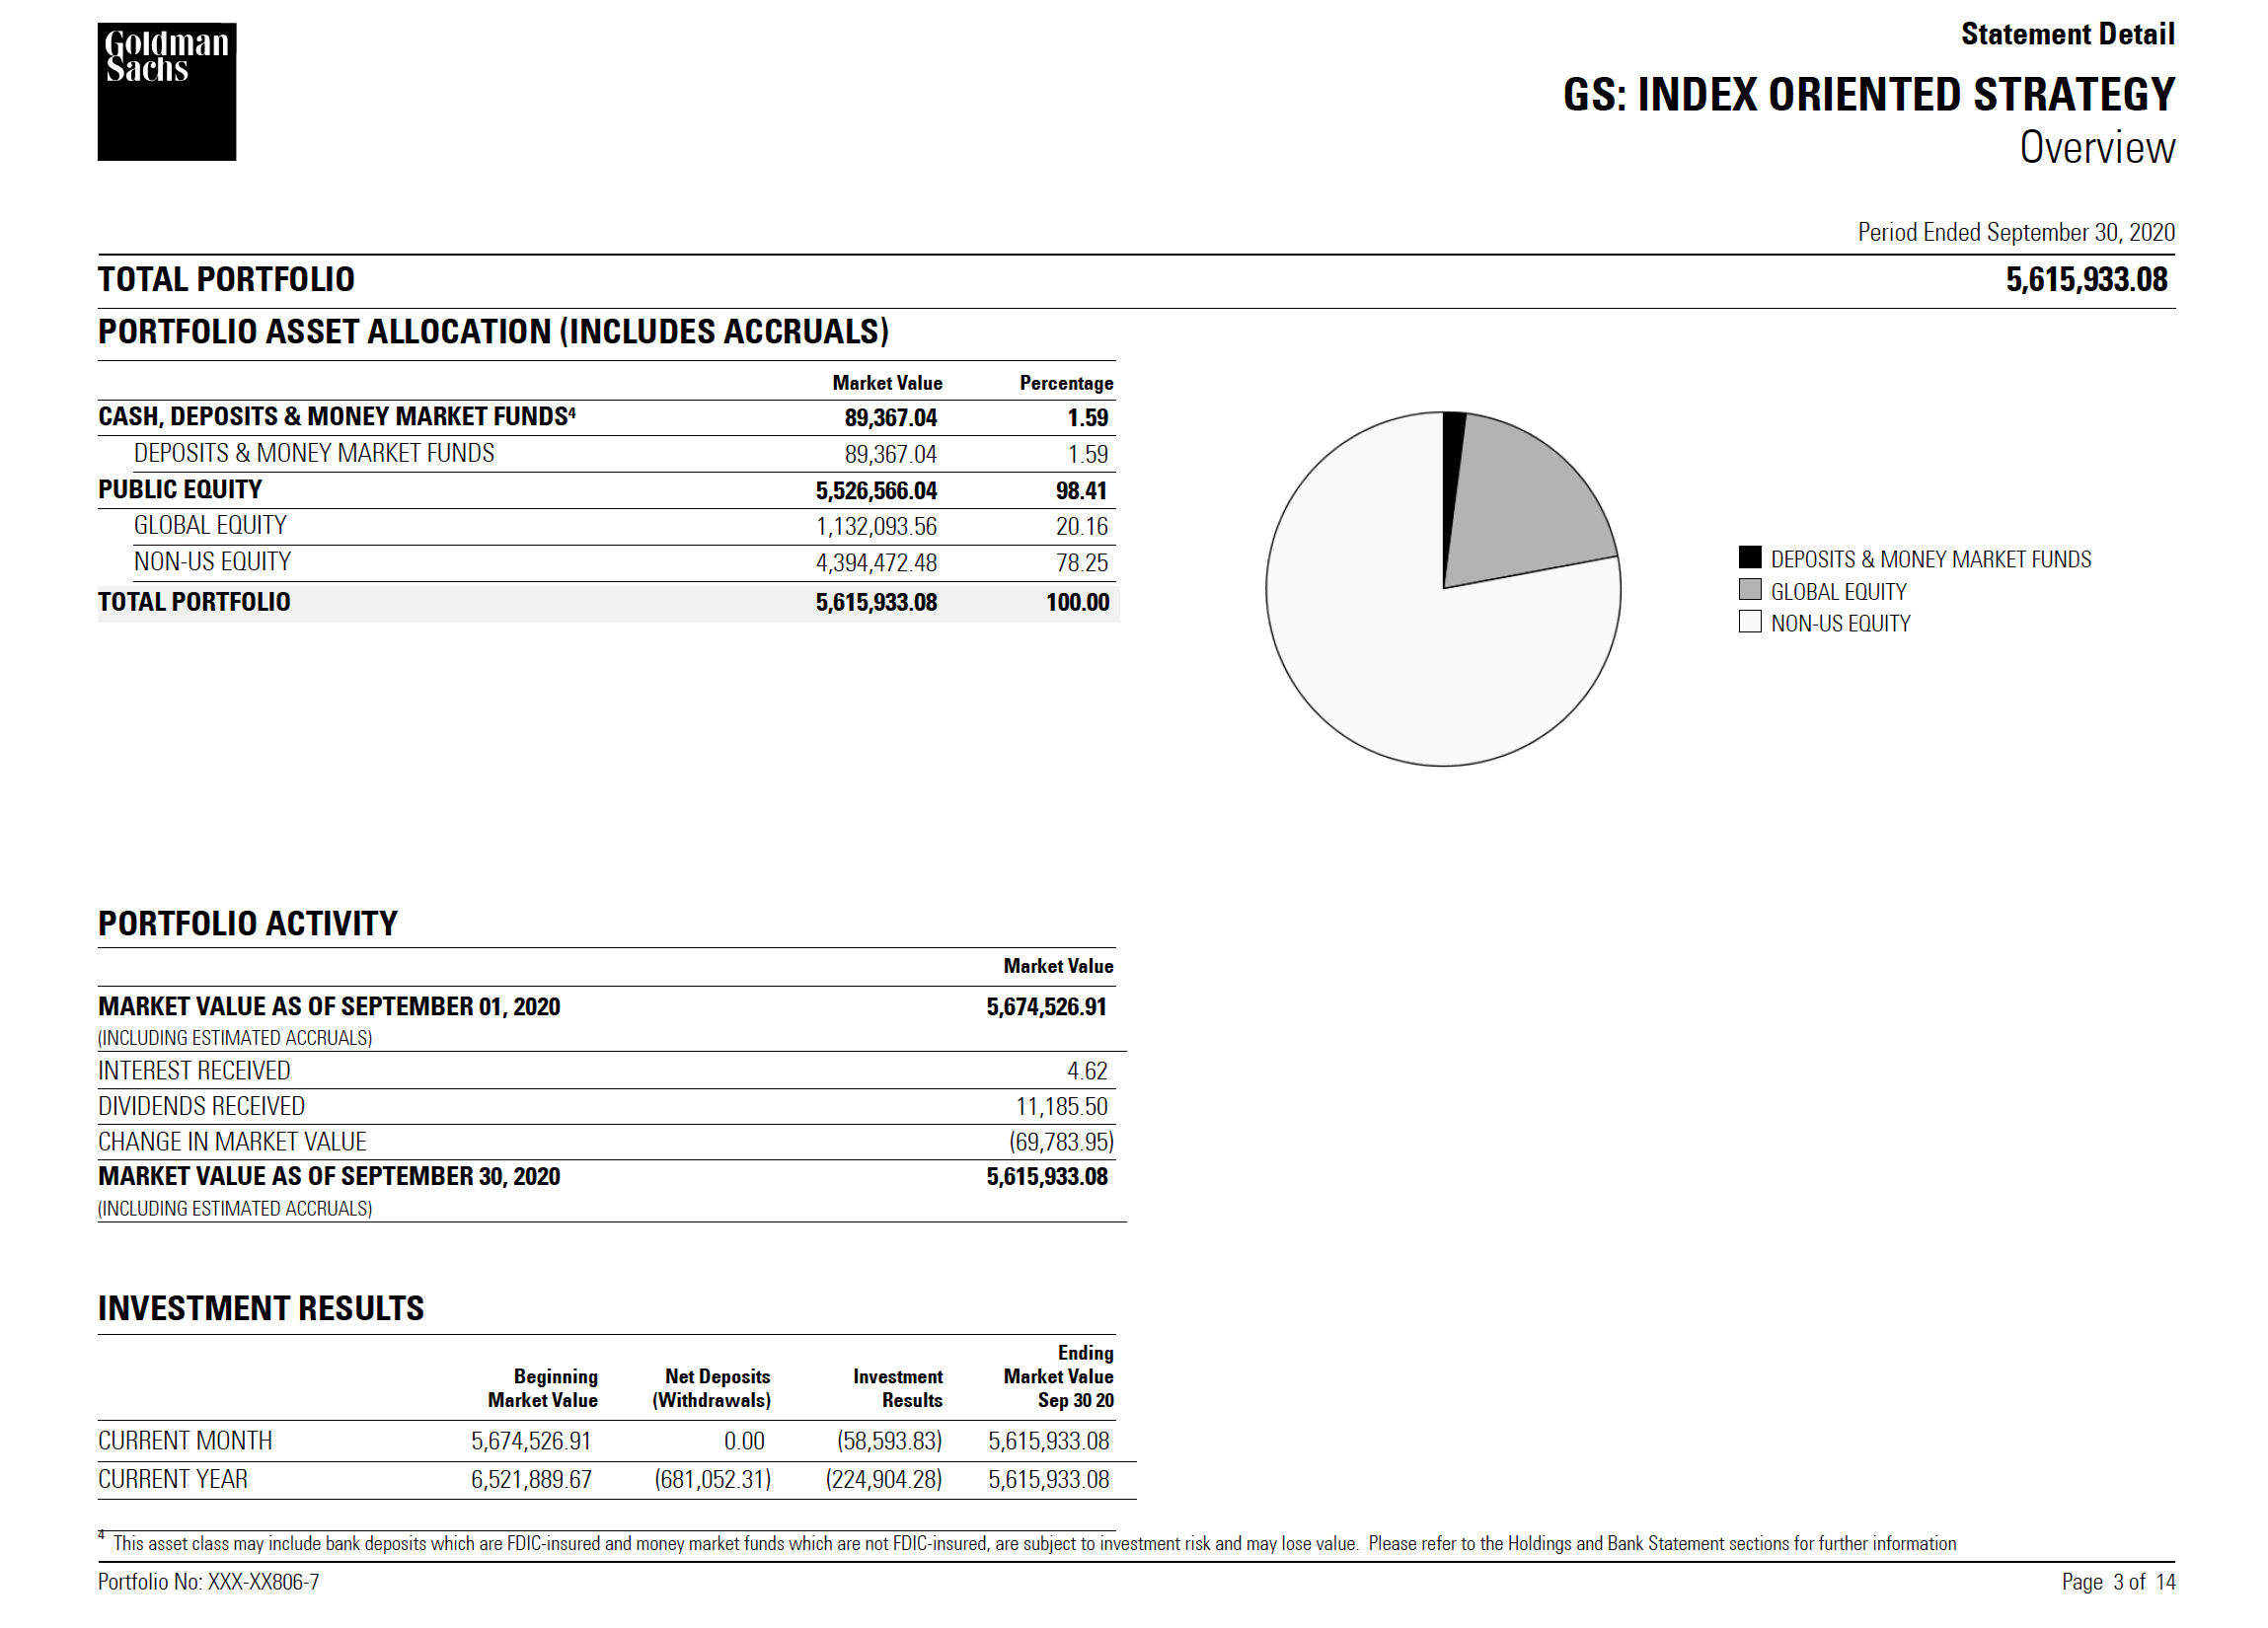

In [12]:
table_image_path = "./data/visual/tables/table.png"

table_image_df= spark.read.format("binaryFile").load(table_image_path)

display_images(BinaryToImage().setImageType(ImageType.TYPE_3BYTE_BGR).transform(table_image_df), "image")

In [13]:
binary_to_image = BinaryToImage() \
    .setInputCol("content") \
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

table_detector = ImageTableDetector() \
    .pretrained("table_detection_v3", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("table_regions") \
    .setScoreThreshold(0.5) \
    .setApplyCorrection(True)

splitter = ImageSplitRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("table_regions") \
    .setOutputCol("table_image") \
    .setDropCols("image")

text_detector = ImageTextDetector() \
    .pretrained("image_text_detector_opt", "en", "clinical/ocr") \
    .setInputCol("table_image") \
    .setOutputCol("text_regions") \
    .setWithRefiner(False) \
    .setWidth(0)

cell_detector = ImageDocumentRegionDetector() \
    .pretrained("region_cell_detection_v2", "en", "clinical/ocr") \
    .setInputCol("table_image") \
    .setOutputCol("cells") \
    .setScoreThreshold(0.8)

merger = RegionsMerger() \
    .setInputCols(["text_regions"]) \
    .setCellInputCol("cells") \
    .setImageInputCol("table_image") \
    .setOutputCol("merged_regions") \
    .setKeepTextRegions(True)

draw_regions = ImageDrawRegions() \
    .setInputCol("table_image") \
    .setInputRegionsCol("merged_regions") \
    .setOutputCol("image_with_merged_regions") \
    .setRectColor(Color.green)

img_to_hocr = ImageToTextV2() \
    .pretrained("ocr_base_printed_v2", "en", "clinical/ocr") \
    .setInputCols(["table_image"]) \
    .setOutputFormat(OcrOutputFormat.HOCR) \
    .setOutputCol("hocr") \
    .setGroupImages(False) \
    .setRegionsColumn("merged_regions") \
    .setIncludeConfidence(True)

hocr_to_table = HocrToTextTable() \
    .setInputCol("hocr") \
    .setOutputCol("table") \
    .setUseCellsCol("cells")

pipeline = PipelineModel(stages=[
    binary_to_image,
    table_detector,
    splitter,
    text_detector,
    cell_detector,
    merger,
    draw_regions,
    img_to_hocr,
    hocr_to_table
])

table_detection_v3 download started this may take some time.


25/10/19 17:35:18 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.
25/10/19 17:35:19 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


Approximate size to download 23.1 MB
image_text_detector_opt download started this may take some time.
Approximate size to download 75.8 MB
region_cell_detection_v2 download started this may take some time.


25/10/19 17:35:19 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


Approximate size to download 23.1 MB


25/10/19 17:35:19 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.
25/10/19 17:35:19 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


ocr_base_printed_v2 download started this may take some time.
Approximate size to download 862 MB
Download done! Loading the resource.


In [14]:
result = pipeline.transform(table_image_df).cache()
result.columns

['image',
 'path',
 'modificationTime',
 'length',
 'pagenum',
 'table_image',
 'table_regions',
 'text_regions',
 'cells',
 'merged_regions',
 'image_with_merged_regions',
 'hocr',
 'confidence',
 'positions',
 'table',
 'exception',
 'table_index']

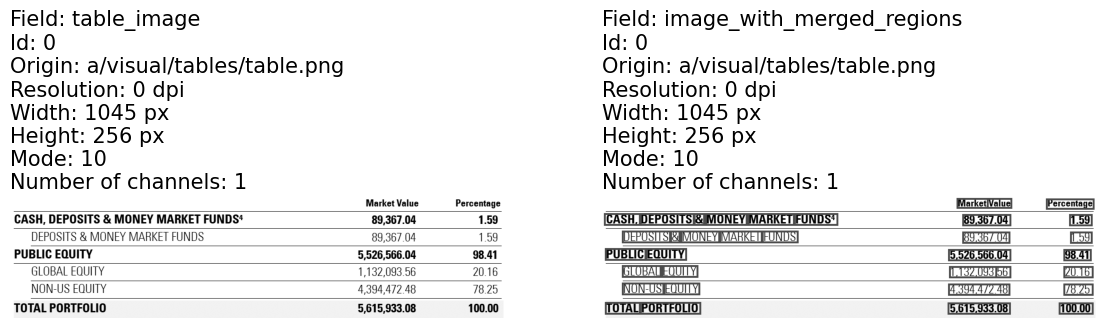

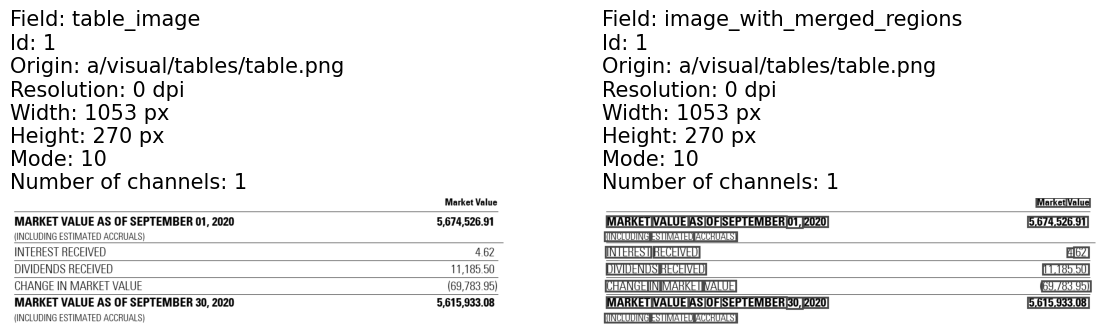

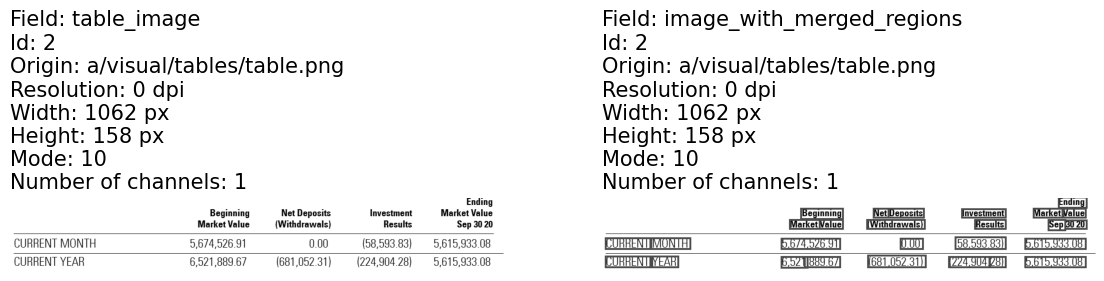

In [15]:
display_images_horizontal(result, "table_image,image_with_merged_regions")

In [16]:
result = result.drop("table_index").withColumn("table_id", F.monotonically_increasing_id())

display_tables(result, table_index_col = "table_id", empty_val = "")

Filename: table.png
Page: 0
Table: 0
Number of Columns: 3


col0,col1,col2
,MARKET VALUE,PERCENTAGE
"CASH, DEPOSITS & MONEY MARKET FUNDS4","89,367.04",1.59
DEPOSITS & MONEY MARKET FUNDS,"89,367.04",1.59
PUBLIC EQUITY,"5,526,566.04",98.41
GLOBAL EQUITY,"1,132,093 56",20.16
NON-US EQUITY,"4,394,472.48",78.25
TOTAL PORTFOLIO,"5,615,933.08",100.00


Filename: table.png
Page: 0
Table: 1
Number of Columns: 2


col0,col1
"MARKET VALUE AS OF SEPTEMBER 01, 2020","5,674,526.91"
(INCLUDING ESTIMATED ACCRUALS),
INTEREST RECEIVED,4 62
DIVIDENDS RECEIVED,"11,185.50"
CHANGE IN MARKET VALUE,"69,783.95)"
"MARKET VALUE AS OF SEPTEMBER 30, 2020","5,615,933.08"
(INCLUDING ESTIMATED ACCRUALS),


Filename: table.png
Page: 0
Table: 2
Number of Columns: 5


col0,col1,col2,col3,col4
,BEGINNING MARKET VALUE,NET DEPOSITS (WITHDRAWALS),INVESTMENT RESULTS,ENDING MARKET VALUE SEP 30.20
CURRENT MONTH,"5,674,526.91",0.00,"(58,593.83)","5,615,933.08"
CURRENT YEAR,"6,521, ,889.67","(681,052.31)","(224,904 28)","5,615,933.08"


<h1>HOCR Table Recognition Using ImageToTextV2</h1>

In [17]:
table_image_path = ["./data/visual/tables/table1.png", 
                    "./data/visual/tables/table4_1.jpg",
                    "./data/visual/tables/1-s2__3.jpg"]

table_image_df = spark.read.format("binaryFile").load(table_image_path)

print(f"Total Number of Images : {table_image_df.count()}", end="\n\n")

table_image_df.columns

Total Number of Images : 3



['path', 'modificationTime', 'length', 'content']

In [19]:
binary_to_image = BinaryToImage() \
    .setInputCol("content") \
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

table_detector = ImageTableDetector() \
    .pretrained("general_model_table_detection_v2", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("table_regions")

splitter = ImageSplitRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("table_regions") \
    .setOutputCol("table_image") \
    .setDropCols("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

text_detector = ImageTextDetectorV2() \
    .pretrained("image_text_detector_v2", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("text_regions") \
    .setWithRefiner(True)

draw_regions = ImageDrawRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("text_regions") \
    .setOutputCol("image_with_regions") \
    .setRectColor(Color.green)

img_to_hocr = ImageToTextV2() \
    .pretrained("ocr_base_printed_v2_opt", "en", "clinical/ocr") \
    .setInputCols(["image"]) \
    .setOutputFormat(OcrOutputFormat.HOCR) \
    .setRegionsColumn("text_regions") \
    .setOutputCol("hocr") \
    .setGroupImages(False) \
    .setUseGPU(False)

hocr_to_table = HocrToTextTable() \
    .setInputCol("hocr") \
    .setRegionCol("table_regions") \
    .setOutputCol("tables")

table_hocr_pipeline = PipelineModel(stages=[
    binary_to_image,
    table_detector,
    splitter,
    text_detector,
    draw_regions,
    img_to_hocr,
    hocr_to_table
])

general_model_table_detection_v2 download started this may take some time.
Approximate size to download 264.7 MB
image_text_detector_v2 download started this may take some time.
Approximate size to download 75.3 MB


25/10/19 17:36:47 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.
25/10/19 17:36:47 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


In [20]:
result = table_hocr_pipeline.transform(table_image_df).cache()
result.columns

['text_regions',
 'path',
 'modificationTime',
 'length',
 'pagenum',
 'table_image',
 'table_regions',
 'image',
 'image_with_regions',
 'hocr',
 'confidence',
 'positions',
 'tables',
 'exception',
 'table_index']

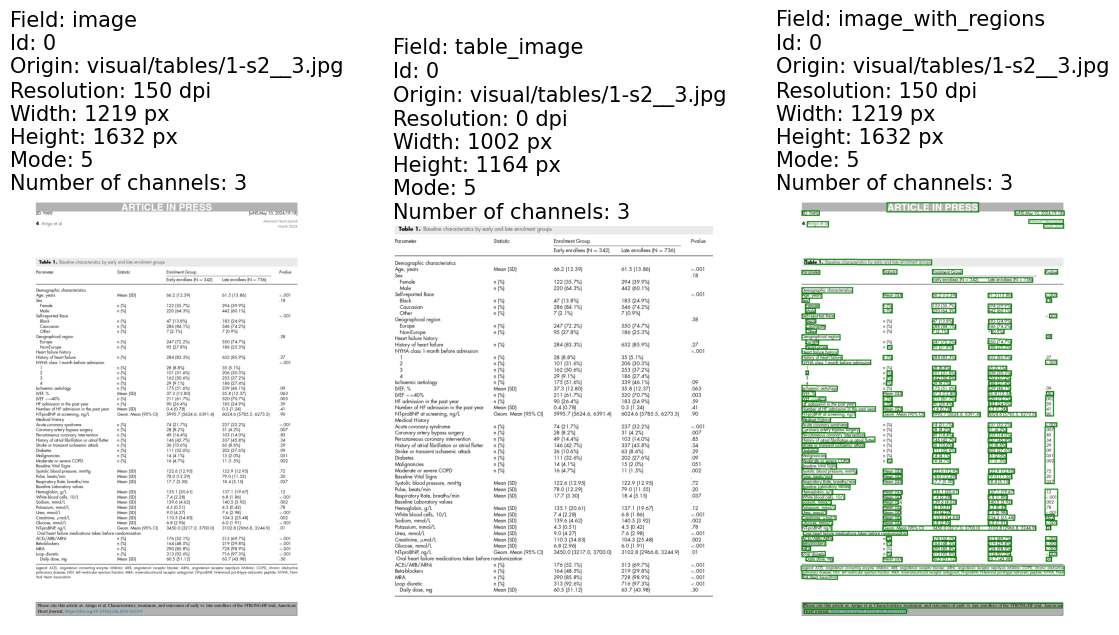

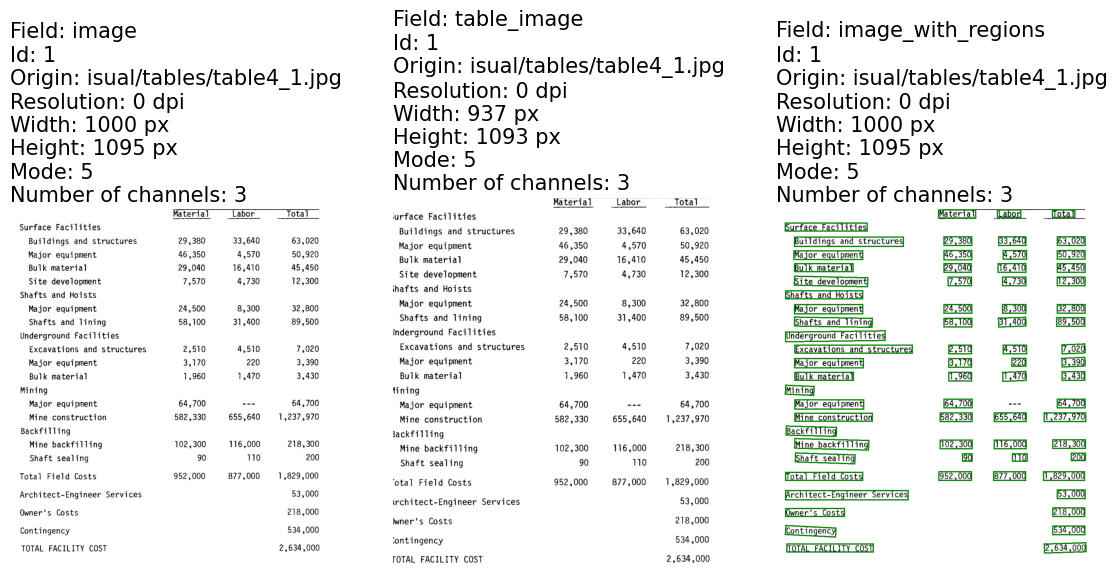

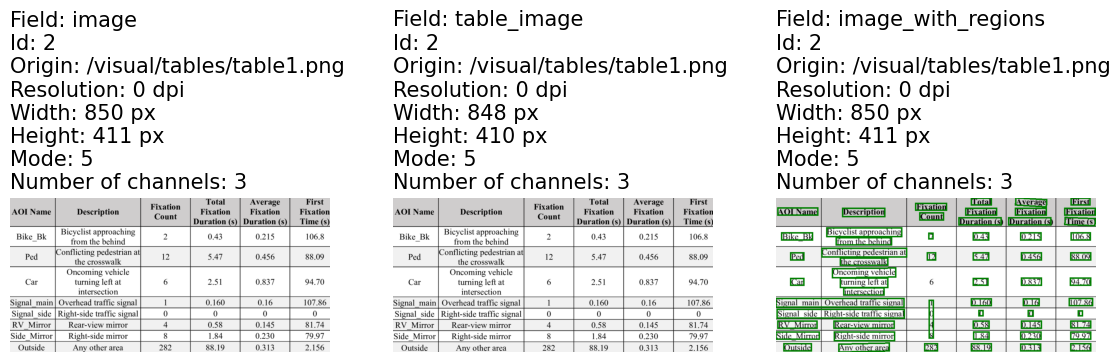

In [22]:
display_images_horizontal(result, "image,table_image,image_with_regions")

In [23]:
display_tables(result, table_col = "tables", table_index_col = "table_index")

Filename: 1-s2__3.jpg
Page: 0
Table: 0
Number of Columns: 6


col0,col1,col2,col3,col4,col5
PARAMETER,,STATISTIC,ENROLMENT GROUP EARRY ENROLIES (N = 342) LATE ENROLLES (N = 736),,P-VALUE
DEMOGRAPHIC CHARACTERISTICS,Empty,Empty,Empty,Empty,Empty
"AGE, YEARS",Empty,MEAN (SD),66.2 (12.39),61.5 (13.86),<.001
SEX,Empty,Empty,Empty,Empty,18
FEMALE,Empty,N (%),122 (35.7%),294 (39.9%),Empty
MALE,Empty,N (%),220 (64.3%),442 (60.1%),Empty
SELF-REPORTED RACE,Empty,Empty,Empty,Empty,001
BLACK,Empty,Empty,47 (13.8%),183 (24.9%),Empty
CAUCASIAN,Empty,Empty,286 (84.1%),546 (74.2%),Empty
OTHER,Empty,Empty,7 (2.1%),(0.9%),Empty


Filename: table1.png
Page: 0
Table: 0
Number of Columns: 7


col0,col1,col2,col3,col4,col5,col6
Empty,Empty,FIXATION,Empty,TOTAL,AVERAGE,FIRST
AOI NAME,DESCRIPTION BICYCLIST APPROACHING,COUNT,DURATION (S) DURATION (S),FIXATION,FIXATION,FIXATION TIME (S)
BIKE BK,FROM THE BEHIND CONFICTING PEDESTRIAN AT,2,,0.43,0.215,106.8
PED,THE CROSSWALK ONCOMING VEHICLE,12,,5.47,0.456,88.09
CAR,TURNING LEFT AT INTERSECTION SIDE MINOR SIGNAL MAIN OVERHEAD TRAFFIC SIGNAL RIGHT-SIDE MINOR SIGNAL SIDE |RIGHT-SIDE TRAFIC SIGNAL,0.00,,2.51 0.160 1.84 0,0.837 0.230 0.16 0,94.70 107.86 79.97 0
RV MIROR,REAR-VIEW MINOR,Empty,Empty,0.58,0.145,81.74
OUTSIDE,ANY OTHER AREA,282,Empty,88.19,0.313,2.156


Filename: table4_1.jpg
Page: 0
Table: 0
Number of Columns: 4


col0,col1,col2,col3
Empty,MATERIAL,LABOR,TOTAL
SURFACE FACILITIES,Empty,Empty,Empty
BUILDINGS AND STRUCTURES,"29,380","33,640","63,020"
MAJOR EQUIPMENT,"46,350","4,570","50,920"
BULK MATERIAL,"29,040","16,410","45,450"
SITE DEVELOPMENT,"7,570","4,730","12,300"
SHAPTS AND HOISTS,Empty,Empty,Empty
MAJOR EQUIPMENT,"24,500","8,300","32,800"
SHAFTS AND INING,"58,100","31,400","89,500"
UNDERGROUND FACILITIES,Empty,Empty,Empty


<h1>Image Recognition Using HOCR : CSV Output Format </h1>

In [24]:
table_image_path = ["./data/visual/tables/cTDaR_t10096.jpg"]

table_image_df = spark.read.format("binaryFile").load(table_image_path)

table_image_df.columns

['path', 'modificationTime', 'length', 'content']

In [25]:
binary_to_image = BinaryToImage() \
    .setInputCol("content") \
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

table_detector = ImageTableDetector() \
    .pretrained("general_model_table_detection_v2", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("table_regions")

splitter = ImageSplitRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("table_regions") \
    .setOutputCol("table_image") \
    .setDropCols("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

text_detector = ImageTextDetectorV2() \
    .pretrained("image_text_detector_v2", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("text_regions") \
    .setWithRefiner(True)

draw_regions = ImageDrawRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("table_regions") \
    .setOutputCol("image_with_table_regions") \
    .setRectColor(Color.green)

img_to_hocr = ImageToTextV2() \
    .pretrained("ocr_base_printed_v2_opt", "en", "clinical/ocr") \
    .setInputCols(["image"]) \
    .setOutputFormat(OcrOutputFormat.HOCR) \
    .setRegionsColumn("text_regions") \
    .setOutputCol("hocr") \
    .setGroupImages(False) \
    .setUseGPU(False)

hocr_to_table = HocrToTextTable() \
    .setInputCol("hocr") \
    .setRegionCol("table_regions") \
    .setOutputCol("csv") \
    .setOutputFormat(TableOutputFormat.CSV)

table_hocr_pipeline = PipelineModel(stages=[
    binary_to_image,
    table_detector,
    splitter,
    text_detector,
    draw_regions,
    img_to_hocr,
    hocr_to_table
])

general_model_table_detection_v2 download started this may take some time.


25/10/19 17:39:47 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.
25/10/19 17:39:47 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


Approximate size to download 264.7 MB
image_text_detector_v2 download started this may take some time.
Approximate size to download 75.3 MB


In [26]:
result = table_hocr_pipeline.transform(table_image_df)
result.columns

['text_regions',
 'path',
 'modificationTime',
 'length',
 'pagenum',
 'table_image',
 'table_regions',
 'image',
 'image_with_table_regions',
 'hocr',
 'confidence',
 'positions',
 'csv',
 'exception',
 'table_index']

In [ ]:
csv_data = result.select("csv").collect()[0].csv
data_io = StringIO(csv_data)

df = pd.read_csv(data_io, sep=r",")

In [32]:
df.head(100)

,Unnamed: 0,SERIES B,PURCHASE
0,NAME OF SHAREHOLDER,PREFERRED SHARES,AMOUNT (USS)
1,WUXI HEALTHCARE VENTURES,"882,861","4,999,994.99"
2,"6 DIMENSIONS CAPITAL, L.P.","3,354,875","18,999,999.08"
3,DIMENSIONS AFILIATES FUND. L.P.,176.572,"999,997.87"
4,GRACEFUL BEAUTY LIMITED,"4,237,737","23,999,999.73"
5,TETRAD VENTURES PTE LTD,"8,828,618","49,999,995.19"
6,HIKEO BIOTECH L.P.,"1,589,151","8,999,997.78"
7,PURE PROGRESS INTERNATIONAL LIMITED,"1,765,723","9,999,995.64"
8,KAITAI INTERNATIONAL FUNDS SPC,"882,861","4,999,994.99"
9,TAIKANG KAITAI (PAYMAN) SPECIAL,NaN,NaN
